# Open problems - Single cell perturbations
## Combining gene expression modeling + Limma
#### by Antoine Passemiers

---

## Table of contents:
* [Install dependencies and import libraries](#dependencies)
* [Model design](#model)
* [Python-Limma interface](#limma)
* [Quick quality control on the predictions](#qc)

In this notebook, we implemented a neural network to estimate gene expression and use Limma to convert estimated RNA counts to DE values. We prealably saved the normalized read counts, as produced by the `voom` R function from the `limma` package. 

<h1 id="dependencies">Install dependencies and import libraries</h1> <a class="anchor" id="dependencies"></a>

Let's first install R. It is a very time-consuming process, so please be patient.

In [1]:
import subprocess
subprocess.run(
    'conda install --repodata-fn repodata.json -c conda-forge r-base',
    shell=True,
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL
)

CompletedProcess(args='conda install --repodata-fn repodata.json -c conda-forge r-base', returncode=0)

In [2]:
!pip install rpy2 category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.3/219.3 kB 4.4 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for rpy2: filename=rpy2-3.5.14-cp310-cp310-linux_x86_64.whl size=261696 sha256=64f8e0a64d3174e33c81bde3b6faf3923d7f54001827510ef32e12ae507ac764
  Stored in directory: /root/.cache/pip/wheels/d4/b5/2f/529c5de71addd73d8e3c51104721d9e084c97ed2ce1c69de2d
Successfully built rpy2


Next we import all the librariries used in this notebook.

In [3]:
import os
import random
import warnings
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.decomposition import KernelPCA
import pandas as pd
import tqdm
import torch

import category_encoders
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
from rpy2.robjects.packages import importr
import rpy2.rinterface as ri
pandas2ri.activate()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


For the sake of reproducibility, we set the seed for the `random`, `numpy` and `torch` libraries.

In [4]:
SEED = 0xCAFE

random.seed(SEED)
np.random.seed(SEED)
torch.use_deterministic_algorithms(True)
torch.set_num_threads(1)
torch.manual_seed(SEED)

#### Load data

In [5]:
# Data locations
DATA_FOLDER = '/kaggle/input/open-problems-single-cell-perturbations/'
EXTERNAL_DATA_FOLDER = '/kaggle/input/op2-expression-data/'

# Cell types consistently present in the training set
INPUT_CELL_TYPES = ['NK cells', 'T cells CD4+', 'T regulatory cells']
# INPUT_CELL_TYPES = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']

# Cell types composing the test set
OUTPUT_CELL_TYPES = ['Myeloid cells', 'B cells']

# All cell types
CELL_TYPES = INPUT_CELL_TYPES + OUTPUT_CELL_TYPES


df = pd.read_parquet(os.path.join(DATA_FOLDER, 'de_train.parquet'))

cell_types = df['cell_type']
sm_names = df['sm_name']
sm_lincs_ids = df['sm_lincs_id']
all_smiles = df['SMILES']
is_control = df['control']

groups = LabelEncoder().fit_transform(sm_names)

for col_name in ['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control']:
    df.drop(col_name, axis=1, inplace=True)
data = df.to_numpy(dtype=float)

unique_smiles = list(set(all_smiles))
smiles_dict = {smiles: i for i, smiles in enumerate(unique_smiles)}
unique_cell_types = list(set(cell_types))
unique_sm_names = list(set(sm_names))
cell_type_dict = {cell_type: i for i, cell_type in enumerate(unique_cell_types)}
sm_name_dict = {sm_name: i for i, sm_name in enumerate(unique_sm_names)}
sm_name_dict['Dimethyl Sulfoxide'] = len(sm_name_dict)
gene_names = list(df.columns)
gene_name_dict = {gene_name: i for i, gene_name in enumerate(gene_names)}
sm_name_to_smiles = {sm_name: smiles for sm_name, smiles in zip(sm_names, all_smiles)}
donor_dict = {f'donor_{i}': i for i in range(3)}
plate_name_dict = {f'plate_{i}': i for i in range(6)}
row_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7}

<h1 id="model">Model design</h1> <a class="anchor" id="model"></a>

Our neural architecture draws inspiration from the model we built on DE. Due to the data being drastically different we made some adjustments to account for the peculiarities of this dataset. In the present case, the inputs consist of not only the cell type and compound, but also the library, the donor and the plate. Because `Limma`'s `lmFit` is expecting both normalized RNA counts and weights as input, we designed a branching a neural network with shared parameters in its upstream part, and separate branches downstream to estimate the normalized RNA counts and corresponding weights, separately. The output of the weights regressor was applied a ReLU activation to ensure the positivity of the weights. We did not do so for the normalized RNA counts, as we noticed that the `voom` function can return negative values in practice.

In [6]:
class NN(torch.nn.Module):
    """Deep learning architecture that predicts normalized gene expression and weights
    from covariates.
    
    Input features are the target encodings of cell type, compound, library, donor and plate,
    with respect to each gene.
    
    Attributes:
        n_in_channels: Number of covariates (5).
        n_out_channels: An arbitrary number (e.g., 5).
        n_in: Number of inputs, equal to `n_genes`.
        n_out: Number of outputs, equal to `n_genes`.
        encoder: Upstream part of the model. A simple MLP taking a tensor of shape
            `(batch_size, n_in_channels * n_genes)` as input and producing a tensor of shape
            `(batch_size, n_out_channels * n_genes)` as output.
        gene_regressor: Downstream predictor for normalized gene expression. A simple MLP
            taking a tensor of shape `(batch_size * n_genes, n_in_channels + n_out_channels)`
            as input and producing a tensor of shape (batch_size * n_genes, 1)` as output.
        weight_regressor: Downstream predictor for the weights associated with the normalized
            gene expression. A simple MLP taking a tensor of shape
            `(batch_size * n_genes, n_in_channels + n_out_channels)` as input and producing 
            a tensor of shape (batch_size * n_genes, 1)` as output.
    """
    
    def __init__(self, n_out: int):
        torch.nn.Module.__init__(self)
        
        self.n_in_channels: int = 5
        self.n_out_channels: int = 5
        self.n_in: int = n_out
        self.n_out: int = n_out
            
        # Upstream MLP
        self.encoder = torch.nn.Sequential(
            
            torch.nn.Linear(self.n_in * self.n_in_channels, 128),
            torch.nn.PReLU(128),
            
            torch.nn.Linear(128, 256),
            #torch.nn.BatchNorm1d(256),
            torch.nn.PReLU(256),
            #torch.nn.Dropout(0.2, inplace=False),
            
            torch.nn.Linear(256, 256),
            torch.nn.PReLU(256),
            #torch.nn.Dropout(0.2, inplace=False),
            
            torch.nn.Linear(256, 128),
            torch.nn.PReLU(128),
            #torch.nn.BatchNorm1d(128),
            #torch.nn.Dropout(0.2, inplace=False),
            
            torch.nn.Linear(128, 128),
            torch.nn.PReLU(128),
            
            torch.nn.Linear(128, self.n_out * self.n_out_channels),
        )
        
        # Downstream MLP for predicting normalized RNA counts
        self.gene_regressor = torch.nn.Sequential(
            
            torch.nn.Linear(10, 128),
            torch.nn.PReLU(128),
            
            torch.nn.Linear(128, 128),
            torch.nn.PReLU(128),
            
            torch.nn.Linear(128, 1),
        )
        
        # Downstream MLP for predicting the weights associated to RNA counts
        self.weight_regressor = torch.nn.Sequential(
            
            torch.nn.Linear(10, 64),
            torch.nn.PReLU(64),
            
            torch.nn.Linear(64, 64),
            torch.nn.PReLU(64),
            
            torch.nn.Linear(64, 1),
            torch.nn.ReLU()
        )

        # Xavier initialization
        def init_weights(m):
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.001)
        self.encoder.apply(init_weights)
        self.gene_regressor.apply(init_weights)
        self.weight_regressor.apply(init_weights)
        
    def forward(self, X: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Estimates normalized RNA counts and associated weights from covariates.
        
        Args:
            X: A tensor of shape `(batch_size, n_genes, n_in_channels)`, where
                `n_in_channels` is the number of covariates.
        
        Returns:
            Y: Normalized RNA counts, of shape `(batch_size, n_genes)`.
            W: Weights associated to the tormalized RNA counts, of shape `(batch_size, n_genes)`.
        """
        encoded = self.encoder(X.reshape(len(X), -1)).reshape(len(X), -1, self.n_out_channels)
        
        # Latent space is concatenated to the inputs to avoid data losses.
        encoded = torch.cat((encoded, X), dim=2)
        
        # The inputs are reshaped in such a way that the downstream MLPs will process
        # each gene as an independent observation.
        Y = self.gene_regressor(encoded.reshape(-1, encoded.size()[2])).reshape(len(X), -1)
        W = self.weight_regressor(encoded.reshape(-1, encoded.size()[2])).reshape(len(X), -1)
        return Y, W
    
    def predict(self, X: np.ndarray, n_batches: int = 100) -> Tuple[np.ndarray, np.ndarray]:
        """Estimates normalized RNA counts and associated weights from covariates.
        
        Uses mini-batching to allow `X` to be arbitrarily big. Returns NumPy arrays.
        
        Args:
            X: A tensor of shape `(n, n_genes, n_in_channels)`, where
                `n_in_channels` is the number of covariates.
            n_batches: Number of batches used to split `X`.
        """
        X = torch.FloatTensor(X)
        Y_pred_s, W_pred_s = [], []
        for idx in np.array_split(np.arange(len(X)), n_batches):  # Split into mini-batches
            Y_pred, W_pred = self.forward(X[idx, :])  # Predict
            
            # Convert to NumPy arrays
            Y_pred_s.append(Y_pred.cpu().data.numpy())
            W_pred_s.append(W_pred.cpu().data.numpy())
        
        # Concatenate predictions
        Y_pred = np.concatenate(Y_pred_s, axis=0)
        W_pred = np.concatenate(W_pred_s, axis=0)
        return Y_pred, W_pred

#### Target encoding

In [7]:
df_s, y_s, weights_s = [], [], []
for cell_type in CELL_TYPES:
    cell_type = cell_type.replace('+', '')
    meta_df = pd.read_csv(os.path.join(EXTERNAL_DATA_FOLDER, f'meta-{cell_type}.tsv'), delimiter='\t', header='infer')
    r_data = np.load(os.path.join(EXTERNAL_DATA_FOLDER, f'{cell_type}.npz'))
    y = r_data['expression']  # Gene expression values, of shape (n_samples, n_genes)
    weights = r_data['weights']  # Inverse variance weights, of shape (n_samples, n_genes)
    df_s.append(meta_df)
    y_s.append(y)
    weights_s.append(weights)
meta_df = pd.concat(df_s, axis=0)
y = np.concatenate(y_s, axis=0)
weights = np.concatenate(weights_s, axis=0)

meta_idx = {key: i for i, key in enumerate(zip(*[meta_df[col_name] for col_name in ['sm_name', 'cell_type', 'donor_id', 'plate_name', 'row']]))}

In [8]:
class MultiOutputTargetEncoder:
    """Multi-output target encoder.
    
    Each input (categorical) feature will be encoded based on each (continuous) output variable.
    
    Attributes:
        encoders: List of encoders, of shape `n_genes`.
    """
    
    def __init__(self):
        self.encoders: List[category_encoders.leave_one_out.LeaveOneOutEncoder] = []
        
    @staticmethod
    def new_encoder() -> category_encoders.leave_one_out.LeaveOneOutEncoder:
        """Instantiates a new gene-specific target encoder.
        
        Returns:
            New instance of a target encoder.
        """
        return category_encoders.leave_one_out.LeaveOneOutEncoder(return_df=False)
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """Fit the encoders for each input feature and output variable.
        
        Args:
            X: Array of shape `(n, n_features)` containing categories as strings or integers.
                In the present case `n_features` is equal to 5
                (cell type, compound, library, donor, plate).
            y: Array of shape `(n, n_genes)` containing the DE values for all the genes.
        """
        self.encoders = []
        for j in tqdm.tqdm(range(y.shape[1]), desc='fit LOO encoders'):
            self.encoders.append(MultiOutputTargetEncoder.new_encoder())
            self.encoders[-1].fit(X, y[:, j])
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        """Encodes the categories. Assumes the encoders have already been fitted.
        
        Args:
            X: Array of shape `(n, n_features)` containing categories as strings or integers.
        
        Returns:
            Array of shape `(n, n_genes, n_features)` containing the encoding of each input
                feature with respect to each output variable.
        """
        Z = []
        for encoder in tqdm.tqdm(self.encoders, desc='transform LOO encoders'):
            y_hat = encoder.transform(X)
            Z.append(y_hat)
        Z = np.asarray(Z)
        return np.transpose(Z, (1, 0, 2))

Because genes have unequal variances, we standardize their normalized expression first.

In [9]:
scaler = RobustScaler()
y_scaled = scaler.fit_transform(y)

Let's now do the target encoding of the 5 covariates with respect to each gene. This will result in a tensor of shape `(n_samples, n_genes, 5)`.

In [10]:
encoder = MultiOutputTargetEncoder()
encoder.fit(meta_df[['sm_name', 'donor_id', 'plate_name', 'row', 'cell_type']], y_scaled)

fit LOO encoders: 100%|██████████| 18211/18211 [11:28<00:00, 26.44it/s]


In [11]:
X = encoder.transform(meta_df[['sm_name', 'donor_id', 'plate_name', 'row', 'cell_type']])
X = torch.FloatTensor(X)

transform LOO encoders: 100%|██████████| 18211/18211 [05:48<00:00, 52.31it/s]


In [15]:
def train(idx_train, n_iter: int = 10):
    """Trains a neural network and returns it.
    
    Args:
        idx_train: Indices of the training data.
        n_iter: Number of epochs.
    
    Returns:
        Trained model.
    """
    idx_train = np.copy(idx_train)
    
    # Initialize model
    model = NN(len(gene_names))

    # Initialize optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, eps=1e-7)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.9, patience=10, verbose=False, threshold=0.0001,
            threshold_mode='rel', cooldown=2, min_lr=1e-5, eps=1e-08)
    
    pbar = tqdm.tqdm(range(n_iter))
    for epoch in pbar:
        total_loss, baseline_total_loss = 0, 0
        np.random.shuffle(idx_train)
        for it_idx in np.array_split(idx_train, 500):
            
            # Reset gradients
            optimizer.zero_grad()
            
            # Mini-batching of normalized RNA counts and weights
            Y = torch.FloatTensor(y_scaled[it_idx, :])
            W = torch.FloatTensor(weights[it_idx, :])
            W = torch.clamp(W, 0, 100)  # Clip for numerical stability
            
            # Regularization by noise injection
            # Y = Y + 0.5 * torch.randn(*Y.size())
            
            # Forward pass
            Y_pred, W_pred = model.forward(X[it_idx])
            
            # Compute loss function = MSE on RNA counts + 0.5 * MSE on weights
            loss = torch.mean(torch.square(Y - Y_pred))
            loss = loss + 0.5 * torch.mean(torch.square((W - W_pred) / 100))
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            # Update incremental computation of MRRMSE and relative error
            mrrmse = torch.mean(torch.sqrt(torch.mean(torch.square(Y - Y_pred), dim=1)))
            baseline_mrrmse = torch.mean(torch.sqrt(torch.mean(torch.square(Y - torch.mean(Y, dim=0).unsqueeze(0)), dim=1)))
            total_loss += mrrmse.item()
            baseline_total_loss += baseline_mrrmse.item()
            
        rel_error = total_loss / baseline_total_loss
        scheduler.step(rel_error)    
        pbar.set_description(f'{rel_error:.3f}')
    return model

0.812: 100%|██████████| 10/10 [48:56<00:00, 293.61s/it]


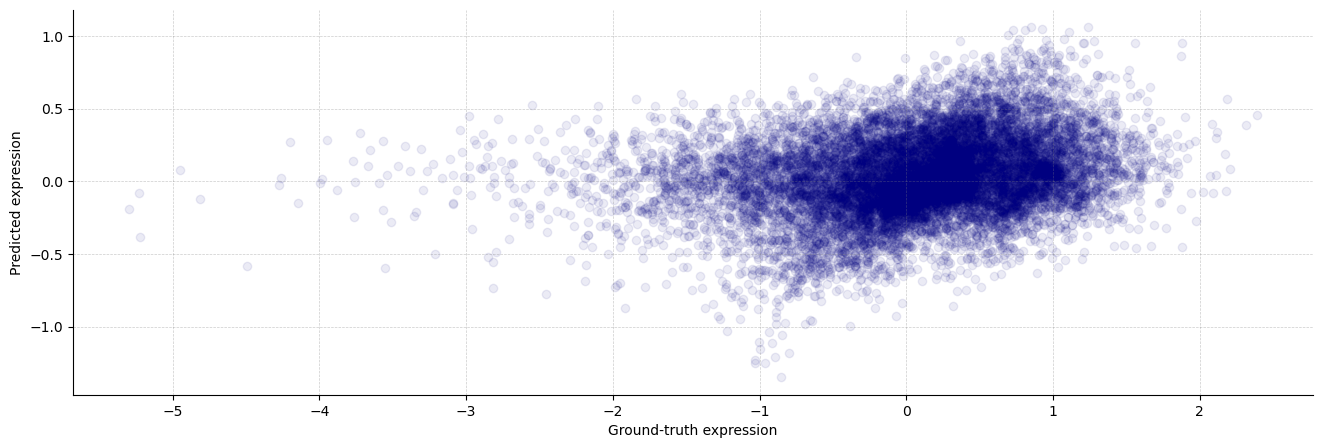

0.7210200902245029
Average relative error: 0.7210200902245029


In [13]:
models = []
rel_errors = []
kf = KFold(n_splits=10, random_state=SEED, shuffle=True)
for i, (train_index, test_index) in enumerate(kf.split(y)):
    
    # Train model
    model = train(train_index)
    model.eval()
    models.append(model)

    # Predict on held-out samples
    Y = torch.FloatTensor(y_scaled[test_index, :])
    Y_pred, W_pred = model.forward(X[test_index])
    
    # Plot predictions for 1st sample
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 1, 1)
    plt.scatter(Y[0, :].cpu().data.numpy(), Y_pred[0, :].cpu().data.numpy(), alpha=0.08, color='navy')
    plt.grid(alpha=0.4, color='grey', linestyle='--', linewidth=0.5)
    ax.spines[['right', 'top']].set_visible(False)
    plt.xlabel('Ground-truth expression')
    plt.ylabel('Predicted expression')
    plt.show()
    
    #mrrmse = torch.mean(torch.abs(Y - Y_pred)).item()
    #baseline_mrrmse = torch.mean(torch.abs(Y - torch.mean(Y, dim=0).unsqueeze(0))).item()
    mrrmse = torch.mean(torch.sqrt(torch.mean(torch.square(Y - Y_pred), dim=1))).item()
    baseline_mrrmse = torch.mean(torch.sqrt(torch.mean(torch.square(Y - torch.mean(Y, dim=0).unsqueeze(0)), dim=1))).item()
    rel_errors.append(mrrmse / baseline_mrrmse)
    print(rel_errors[-1])
    
    break  # For speed
    
print(f'Average relative error: {np.mean(rel_errors)}')

# Average relative error: 0.6952671768202316

In [16]:
model = train(np.arange(len(y)), n_iter=20)

0.766: 100%|██████████| 20/20 [2:08:03<00:00, 384.18s/it]  


<h1 id="limma">Python-Limma interface</h1> <a class="anchor" id="limma"></a>

In [18]:
class Limma:
    
    r_utils = importr('utils')
    r_utils.chooseCRANmirror(ind=1)
    r_utils.install_packages('BiocManager')
    r_biocmanager = importr('BiocManager')
    r_biocmanager.install('limma')
    r_limma = importr('limma')
    r_code = """
    library(limma)
    create_elist <- function(expression, weights) {
        E <- new("EList")
        E$E <- expression
        E$weights <- weights
        return(E)
    }
    make_design <- function(df) {
        for (column in colnames(df)){
            assign(column, df[[column]])
        }
        mm <- model.matrix(eval(parse(text="~0+sm_name+donor_id+plate_name+row")))
        return(mm)
    }
    """
    r_package = SignatureTranslatedAnonymousPackage(r_code, 'custom')
    
    @staticmethod
    def run(df: pd.DataFrame, y: np.ndarray, weights: np.ndarray) -> np.ndarray:
        """Run Limma to obtain the DE values from normalized gene expression.
        
        The inputs `y` and `weights` assume to have been produced by Limma's `voom` function.
        
        Args:
            df: Pandas dataframe containing 4 columns, namely "compound", "donor_id", "plate_name" and "row".
            y: Normalized gene expression values, a matrix of shape (n_samples, n_genes). The number of rows in `df` is 
                equal to the number of rows in `y`.
            weights: Inverse variance weights, a matrix of shape (n_samples, n_genes). The dimensions of `weights`
                should match the dimensions of `y`.
        
        Returns:
            de: A matrix of shape (n_contrasts, n_genes), where `n_contrasts` is the number of compounds after
                excluding "Dimethyl Sulfoxide".
            contrast_dict: 
        """
        
        # Create design matrix and targets
        X = Limma.r_package.make_design(df)
        yw = Limma.r_package.create_elist(
            rpy2.robjects.r.matrix(y.T, nrow=y.T.shape[0], ncol=y.T.shape[1]),
            rpy2.robjects.r.matrix(weights.T, nrow=weights.T.shape[0], ncol=weights.T.shape[1])
        )
        print(f'Design matrix: {X.shape}')

        # Build contrast matrix, also keep track in `contrast_dict` of where each compound
        # is located in design matrix
        sm_name_to_col_idx = {}
        for p in range(len(X)):
            sm_name = df.loc[p, 'sm_name']
            j = np.where(X[p, :])[0][0]
            if sm_name not in sm_name_to_col_idx:
                sm_name_to_col_idx[sm_name] = j
            else:
                assert sm_name_to_col_idx[sm_name] == j
        C = np.zeros((X.shape[1], len(sm_name_to_col_idx) - 1))
        p = 0
        contrast_dict = {}
        unique_sm_names = set(list(df['sm_name']))
        for sm_name in unique_sm_names:
            if sm_name == 'Dimethyl Sulfoxide':
                continue
            if sm_name not in sm_name_to_col_idx:
                continue
            i = sm_name_to_col_idx[sm_name]
            j = sm_name_to_col_idx['Dimethyl Sulfoxide']
            C[i, p] = 1
            C[j, p] = -1
            contrast_dict[sm_name] = p
            p += 1
        print(f'Contrast matrix: {C.shape}')
        
        # Fit linear models
        print(f'Running linear models.')
        fit = Limma.r_limma.lmFit(
            yw,
            rpy2.robjects.r.matrix(X, nrow=X.shape[0], ncol=X.shape[1])
        )
        
        # Replace covariates by their contrasts
        print(f'Computing contrasts.')
        fit = Limma.r_limma.contrasts_fit(
            fit,
            rpy2.robjects.r.matrix(C, nrow=C.shape[0], ncol=C.shape[1])
        )
        
        # Use an empirical Bayes approach to squeeze the residual variances
        print(f'Running empirical Bayes.')
        fit = Limma.r_limma.eBayes(fit)
        
        # Compute DE values
        de = -np.sign(fit.rx2('t')) * np.log10(fit.rx2('p.value'))
        print(f'Done.')
        
        return de, contrast_dict

* installing *source* package ‘BiocManager’ ...
** package ‘BiocManager’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (BiocManager)
* installing *source* package ‘statmod’ ...
** package ‘statmod’ successfully unpacked and MD5 sums checked
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linux-gnu-cc (conda-forge gcc 13.1.0-0) 13.1.0’
using Fortran compiler: ‘GNU Fortran (conda-forge gcc 13.1.0-0) 13.1.0’


x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1689198840511/work=/usr/local/src/conda/r-base-4.3.1 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c expectedDeviance.c -o expectedDeviance.o
x86_64-conda-linux-gnu-gfortran  -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1689198840511/work=/usr/local/src/conda/r-base-4.3.1 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c gaussq2.f -o gaussq2.o
x86_64-conda-linux-gnu-cc -I"/opt/conda

installing to /opt/conda/lib/R/library/00LOCK-statmod/00new/statmod/libs
** R
** data
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (statmod)
* installing *source* package ‘BiocVersion’ ...
** using staged installation
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (BiocVersion)
* installing *source* package ‘limma’ ...
** using staged installation
** libs
using C compiler: ‘x86_64-conda-linu

x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1689198840511/work=/usr/local/src/conda/r-base-4.3.1 -fdebug-prefix-map=/opt/conda=/usr/local/src/conda-prefix  -c init.c -o init.o
x86_64-conda-linux-gnu-cc -I"/opt/conda/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /opt/conda/include -I/opt/conda/include -Wl,-rpath-link,/opt/conda/lib    -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /opt/conda/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1689198840511/work=/usr/local/src/conda/r-base-4.3.1

installing to /opt/conda/lib/R/library/00LOCK-limma/00new/limma/libs
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (limma)


In [19]:
def prepare_data(cell_type, model):
    Y, W = [], []
    compounds, plates, donors, rows, cell_types = [], [], [], [], []
    for plate in [f'plate_{i}' for i in range(6)]:
        for donor in [f'donor_{i}' for i in range(3)]:
            for row in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
                for compound in sm_name_dict.keys():
                    """
                    if (compound, cell_type, donor, plate, row) in meta_idx:
                        i = meta_idx[(compound, cell_type, donor, plate, row)]
                        Y.append(y[i, :])
                        W.append(weights[i, :])
                        ok = True
                    """
                    if random.random() < 0.1:
                        Y.append(np.full(len(gene_names), np.nan))
                        W.append(np.full(len(gene_names), np.nan))
                        ok = True
                    else:
                        ok = False
                    if ok:
                        compounds.append(compound)
                        plates.append(plate)
                        donors.append(donor)
                        rows.append(row)
                        cell_types.append(cell_type)
    Y = np.asarray(Y)
    W = np.asarray(W)
                        
    df = pd.DataFrame({
        'sm_name': np.asarray(compounds),
        'donor_id': np.asarray(donors),
        'plate_name': np.asarray(plates),
        'row': np.asarray(rows),
        'cell_type': np.asarray(cell_types)
    })
    print(df)
    X = torch.FloatTensor(encoder.transform(df))
    Y_pred, W_pred = model.predict(X)
    assert Y.shape == Y_pred.shape
    assert W.shape == W_pred.shape
    
    Y_pred = scaler.inverse_transform(Y_pred)
    print(len(df), Y.shape, W.shape)
    
    return df, Y_pred, W_pred
    

all_de_pred = {}
for cell_type in OUTPUT_CELL_TYPES:
    df, Y, W = prepare_data(cell_type, model)
    de, contrast_dict = Limma.run(df, Y, W)
    de[np.isnan(de)] = 0
    de[np.isinf(de)] = 0
    all_de_pred[cell_type] = (de, contrast_dict)

                   sm_name donor_id plate_name row      cell_type
0                 AZD-8330  donor_0    plate_0   A  Myeloid cells
1              Ruxolitinib  donor_0    plate_0   A  Myeloid cells
2                Nilotinib  donor_0    plate_0   A  Myeloid cells
3                Scriptaid  donor_0    plate_0   A  Myeloid cells
4             Methotrexate  donor_0    plate_0   A  Myeloid cells
...                    ...      ...        ...  ..            ...
2123              Imatinib  donor_2    plate_5   H  Myeloid cells
2124            Canertinib  donor_2    plate_5   H  Myeloid cells
2125             Ceritinib  donor_2    plate_5   H  Myeloid cells
2126       UNII-BXU45ZH6LI  donor_2    plate_5   H  Myeloid cells
2127  Oprozomib (ONX 0912)  donor_2    plate_5   H  Myeloid cells

[2128 rows x 5 columns]


transform LOO encoders: 100%|██████████| 18211/18211 [05:58<00:00, 50.83it/s]


2128 (2128, 18211) (2128, 18211)
Design matrix: (2128, 161)
Contrast matrix: (161, 146)
Running linear models.
Computing contrasts.
Running empirical Bayes.


/tmp/ipykernel_32/4110912516.py:100: RuntimeWarning: divide by zero encountered in log10
  de = -np.sign(fit.rx2('t')) * np.log10(fit.rx2('p.value'))


Done.
                    sm_name donor_id plate_name row cell_type
0                  SLx-2119  donor_0    plate_0   A   B cells
1                 Nilotinib  donor_0    plate_0   A   B cells
2     Ganetespib (STA-9090)  donor_0    plate_0   A   B cells
3                Idelalisib  donor_0    plate_0   A   B cells
4                Dabrafenib  donor_0    plate_0   A   B cells
...                     ...      ...        ...  ..       ...
2050              Tamatinib  donor_2    plate_5   H   B cells
2051                 ABT737  donor_2    plate_5   H   B cells
2052              Riociguat  donor_2    plate_5   H   B cells
2053                 FK 866  donor_2    plate_5   H   B cells
2054             Lamivudine  donor_2    plate_5   H   B cells

[2055 rows x 5 columns]


transform LOO encoders: 100%|██████████| 18211/18211 [05:52<00:00, 51.72it/s]


2055 (2055, 18211) (2055, 18211)
Design matrix: (2055, 161)
Contrast matrix: (161, 146)
Running linear models.
Computing contrasts.
Running empirical Bayes.
Done.


/tmp/ipykernel_32/4110912516.py:100: RuntimeWarning: divide by zero encountered in log10
  de = -np.sign(fit.rx2('t')) * np.log10(fit.rx2('p.value'))


In [21]:
# Load ID mapping
id_map = []
with open(os.path.join(DATA_FOLDER, 'id_map.csv'), 'r') as f:
    lines = f.readlines()[1:]
    for line in lines:
        id_map.append(line.rstrip().split(','))
        assert len(id_map[-1]) == 3

# Make submission
predictions = []
with open('submission.csv', 'w') as f:
    f.write(f'id,{",".join(gene_names)}\n')
    for id_, cell_type, sm_name in tqdm.tqdm(id_map, desc='Submission'):

        # Predict on test sample
        de, contrast_dict = all_de_pred[cell_type]
        i = contrast_dict[sm_name]
        predictions.append(de[:, i])
        
        # Deal with the artifacts caused by numerical instability
        y_hat = np.nan_to_num(de[:, i])
        y_hat = np.clip(y_hat, -100, 100)

        # Write predictions in output file
        values = [f'{x:.5f}' for x in y_hat]
        f.write(f'{id_},{",".join(values)}\n')
predictions = np.asarray(predictions)

Submission: 100%|██████████| 255/255 [00:04<00:00, 57.85it/s]


<h1 id="qc">Quick quality control on the predictions</h1> <a class="anchor" id="qc"></a>

Now that we predicted on the test set, let's investigate whether the predictions overlap with the null distribution. Instead, since we expect most genes and samples to be free of any biological signal, predictions should in principle resemble the distribution of DE values that we could have obtained by random chance.

Let's first define the null distribution, based on the assumption that p-values are uniformly distributed under the null hypothesis.

In [22]:
def background_noise(*size: int, cutoff: float = 1e-7) -> torch.Tensor:
    """Generates random DE values under the null hypothesis.
    
    In the absence of any biological signal, p-values can be expected to be 
    uniformly distributed. Also, positive and negative DE values are equally likely.
    
    Args:
        size: shape of the output tensor.
        cutoff: Significance threshold used to make sure we don't introduce huge outliers in the data.
            This cutoff does not have a real statistical meaning, and is only meant for numerical stability.
            P-values will be randomly and uniformly sampled from the ``[cutoff, 1]`` interval.
    
    Returns:
        Random DE values, stored in a tensor of the desired shape.
    """
    sign = 2 * torch.randint(0, 2, size) - 1
    return sign * torch.log10(cutoff + torch.rand(*size) * (1. - cutoff))

Finally, let's plot our predictions for myeloid and B cells, and compare them against the null distribution.

53.35560149032388
70.410455269667
0.6138715


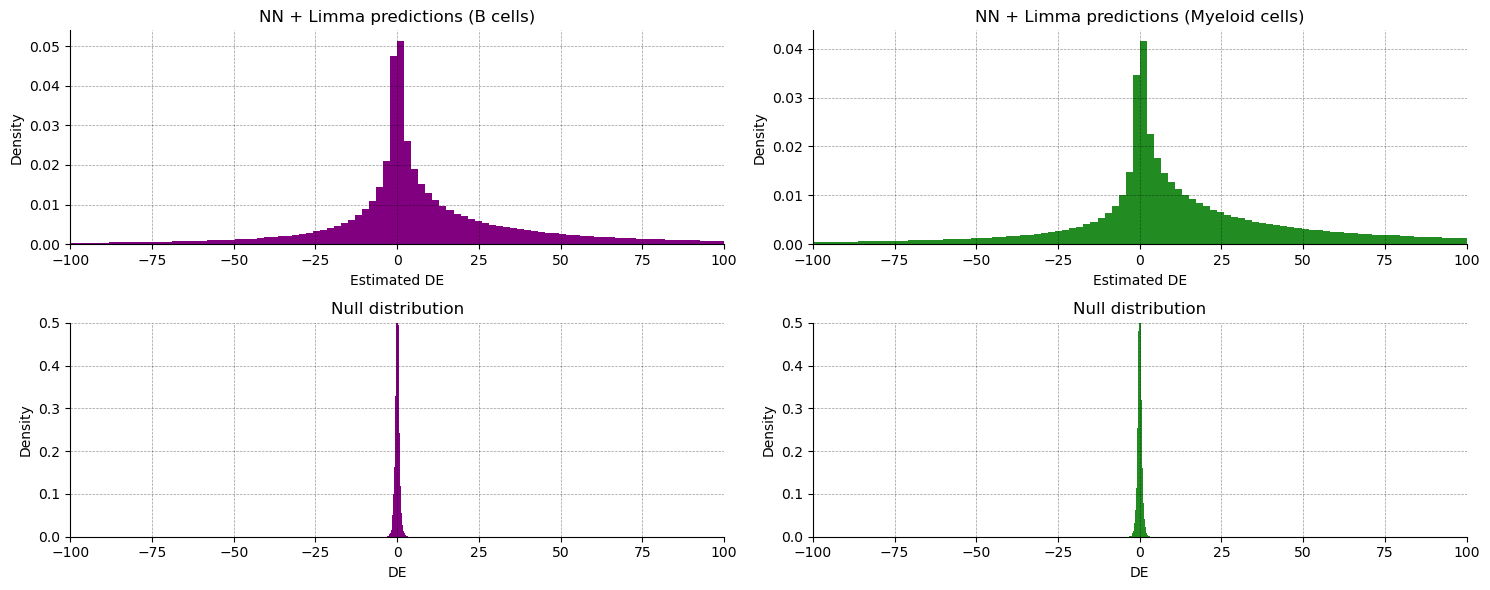

In [26]:
colors = ['purple', 'forestgreen']
plt.figure(figsize=(15, 6))

# Plot the distribution of predicted DE values for B cells
ax1 = plt.subplot(2, 2, 1)
ax1.spines[['right', 'top']].set_visible(False)
plt.title('NN + Limma predictions (B cells)')
ys = predictions[:128].flatten()
ys = ys[ys != 0]
print(np.std(ys))
plt.grid(alpha=0.4, color='black', linewidth=0.5, linestyle='--')
plt.hist(ys, bins=300, color=colors[0], density=True)
plt.xlabel('Estimated DE')
plt.ylabel('Density')
plt.xlim([-100, 100])

# Plot the distribution of predicted DE values for myeloid cells
ax2 = plt.subplot(2, 2, 2)
ax2.spines[['right', 'top']].set_visible(False)
plt.title('NN + Limma predictions (Myeloid cells)')
ys = predictions[128:].flatten()
ys = ys[ys != 0]
print(np.std(ys))
plt.grid(alpha=0.4, color='black', linewidth=0.5, linestyle='--')
plt.hist(ys, bins=300, color=colors[1], density=True)
plt.xlabel('Estimated DE')
plt.ylabel('Density')
plt.xlim([-100, 100])

# Plot the null distribution (DE values obtained when p-values are uniformly distributed)
ys = background_noise(100000).cpu().data.numpy()
print(np.std(ys))
for i in range(2):
    ax = plt.subplot(2, 2, 3 + i, sharex=[ax1, ax2][i])
    ax.spines[['right', 'top']].set_visible(False)
    plt.title('Null distribution')
    plt.grid(alpha=0.4, color='black', linewidth=0.5, linestyle='--')
    plt.hist(ys, bins=300, color=colors[i], density=True)
    plt.ylim([0, 0.5])
    plt.xlabel('DE')
    plt.ylabel('Density')
plt.tight_layout()
plt.savefig('nn+limma-variance.png', dpi=200)
plt.show()

Strikingly, many of the predictions exceed 300. However due to the representation limits of floating-point numbers, many predictions were assigned +inf or -inf, that we excluded from this figure. Neverthless, predictions for B cells have 167 times higher standard deviation than the null distribution, and predictions for Myeloid cells have 228 higher standard deviation.

This is a somewhat unexpected result, as our predicted DE did not exceed the ranges present in the training data. Furthermore, assuming our model behaves as a random predictor, `Limma` should intuitively produce non-significant results. So a better explanation would be that the model artificially introduced strong confounding effects, which is likely to be the case since both biological and technical confounders covariates have been provided as input.